# SI630: Final Project code for 5_org_mngmt classification task

***  

# 1. Loading Data

In [1]:
import re

import pandas as pd
import spacy
import sklearn
from glob import glob
from pprint import pprint

#import pickle
from collections import Counter, defaultdict
import numpy as np
#from numpy import argmax
import scipy
import seaborn as sns
import matplotlib
import math
import random
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from scipy.spatial.distance import cosine
from nltk.corpus import stopwords 
set(stopwords.words('english'))   
#from numba import jit
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve


import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
monster_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/monster_com-job_with_label_columns.csv.xlsx", 
                 error_bad_lines=False, sheet_name="monster_com-job_sample", na_filter=False, encoding= 'utf-8')

In [3]:
monster_df = monster_df.replace({'T':True, 'F':False, '':np.nan})

***  

# 2. Pre-processing: Text Cleaning

In [4]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # Remove Emails
    text = re.sub(r"\S*@\S*\s?", "", text)
    
    # Remove new line characters
    text = re.sub(r"\s+", " ", text)
    
    # Remove single quotes
    text = re.sub(r"\'", "", text)
    
    # Convert text to lowercase
    text = text.strip().lower()
    
    # Remove entity abbreviations
    # Add \b in redgex so that it creates word boundary -(e.g) the word, company, remains company.
    text = re.sub(r",?\s*\b(llc|inc|co)\b\.?", "", text)
    
    # Replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

#pprint(text)
    return text


In [5]:
labeled_rows = monster_df.loc[~monster_df['1_self_mngmt'].isnull()]

In [6]:
X = labeled_rows['job_description']
y = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

***  

### Class Distribution Graph for 215 labeled rows

In [7]:
import seaborn as sns; sns.set()
sns.set_color_codes()

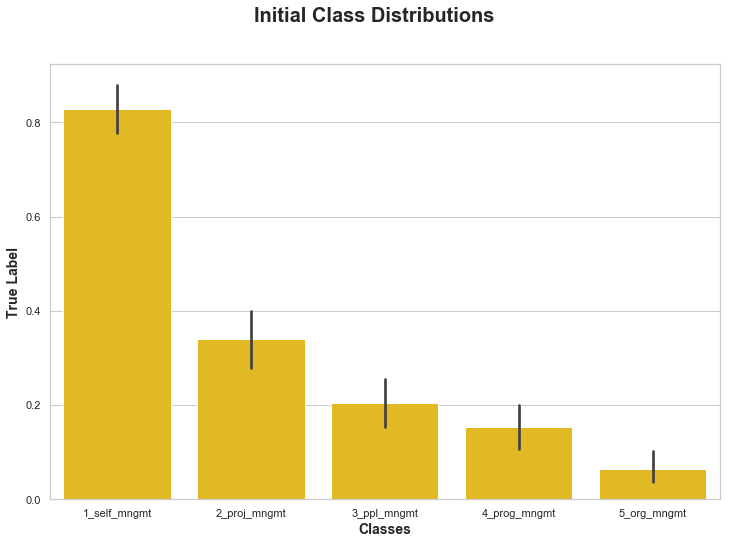

In [8]:
sns.set(style="whitegrid")
colors = ['#ffcb05', '#00274c']
# labels = y[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]
# fig, ax = plt.subplots(1, figsize=(12, 8))
# barplot = plt.bar(labels, height=1, color = 'darkgreen', alpha = 0.85)
# barplot[1].set_color('#00274c')

fig, ax = plt.subplots(1, figsize=(12, 8))
sns.barplot(data=y, color='#ffcb05')
plt.suptitle("Initial Class Distributions", fontsize=20, weight = 'bold')
plt.xlabel('Factors', fontsize = 15, weight = 'bold')
plt.xlabel('Classes', fontsize=14, weight = 'bold')
plt.ylabel('True Label', fontsize=14, weight = 'bold')
plt.show()

# The fraction of True shown
# Right now, I just don't know the true class distribution  --> Later to be addressed this class imbalance but not right now.

***  

# 3. Building A Basic LR Model

In [9]:
stopwords_lst = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

count_vectorizer = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=3, max_df=0.5)

# fit the vectorizer on the training text
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test) 

tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

In [11]:
#count_vectorizer.vocabulary_

In [12]:
X_train

<144x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 17237 stored elements in Compressed Sparse Row format>

In [13]:
X_test

<71x1857 sparse matrix of type '<class 'numpy.float64'>'
	with 7844 stored elements in Compressed Sparse Row format>

In [14]:
y_train = y_train.astype('bool') #(134,5)
#y_train

In [15]:
y_test = y_test.astype('bool') #(12, 5)
y_test.mean()
#y_test.count() #71

1_self_mngmt    0.816901
2_proj_mngmt    0.352113
3_ppl_mngmt     0.183099
4_prog_mngmt    0.126761
5_org_mngmt     0.112676
dtype: float64

***  

# 4. Training The Model & Predicting

In [16]:
classifier = LogisticRegression(solver='lbfgs', class_weight='balanced').fit(X_train, y_train["5_org_mngmt"]) #'liblinear' is the default solver

In [17]:
y_pred = classifier.predict(X_test) #Predict class labels for samples in X
y_pred
#X_train.shape #(16, 1306)
#y_train.shape #(16, 5)
#X_test.shape #(9, 1306)
#y_test.shape #(16, 5)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [18]:
classifier.predict_proba(X_test) #Probability estimates 

array([[0.72034735, 0.27965265],
       [0.76467748, 0.23532252],
       [0.81989433, 0.18010567],
       [0.77248388, 0.22751612],
       [0.57367963, 0.42632037],
       [0.80840283, 0.19159717],
       [0.8017743 , 0.1982257 ],
       [0.7443716 , 0.2556284 ],
       [0.84539233, 0.15460767],
       [0.79189905, 0.20810095],
       [0.80066608, 0.19933392],
       [0.72081014, 0.27918986],
       [0.75925921, 0.24074079],
       [0.83827276, 0.16172724],
       [0.8308089 , 0.1691911 ],
       [0.82257902, 0.17742098],
       [0.81436426, 0.18563574],
       [0.63455005, 0.36544995],
       [0.80276756, 0.19723244],
       [0.54890578, 0.45109422],
       [0.83941869, 0.16058131],
       [0.69921136, 0.30078864],
       [0.82000021, 0.17999979],
       [0.65023821, 0.34976179],
       [0.68254125, 0.31745875],
       [0.75803372, 0.24196628],
       [0.72309706, 0.27690294],
       [0.58505386, 0.41494614],
       [0.74949145, 0.25050855],
       [0.75113301, 0.24886699],
       [0.

***  

# 5. Measurements/ Metrics from the base LR:  

***  

### (1) Accuracy Score

In [19]:
base_lr_accuracy_score = classifier.score(X_test, y_test["5_org_mngmt"])
base_lr_accuracy_score

0.8873239436619719

***  

### (2) F1 Score

In [20]:
print(f1_score(y_test["5_org_mngmt"].astype(bool), y_pred, average='weighted'))  
print(f1_score(y_test["5_org_mngmt"].astype(bool), y_pred, average='macro'))  
print(f1_score(y_test["5_org_mngmt"].astype(bool), y_pred, average='micro'))  
# print(f1_score(y_test["3_ppl_mngmt"], y_pred, average='weighted'))

0.834349379861257
0.47014925373134325
0.8873239436619719


/Users/yukolopez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yukolopez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


***  

### (3) Cross Entropy

In [21]:
log_loss(y_test["5_org_mngmt"], y_pred, eps=1e-15)

3.8916931149195135

***  
### (5) ROC AUC Score

In [22]:
# We need some probabilities:
predicted_prob = classifier.predict_proba(X_test)
roc_auc_score(y_test["5_org_mngmt"].astype(int), predicted_prob[:,1])
# -->0.8055555555555556 returns: Given the random prediction is 0.5, where 1.0 is perfect, any value above 0.5 is good.  
#This looks at the probabilities, and it will provide more fine-grained view of how the model is doing compared to acc score.  

0.9603174603174602

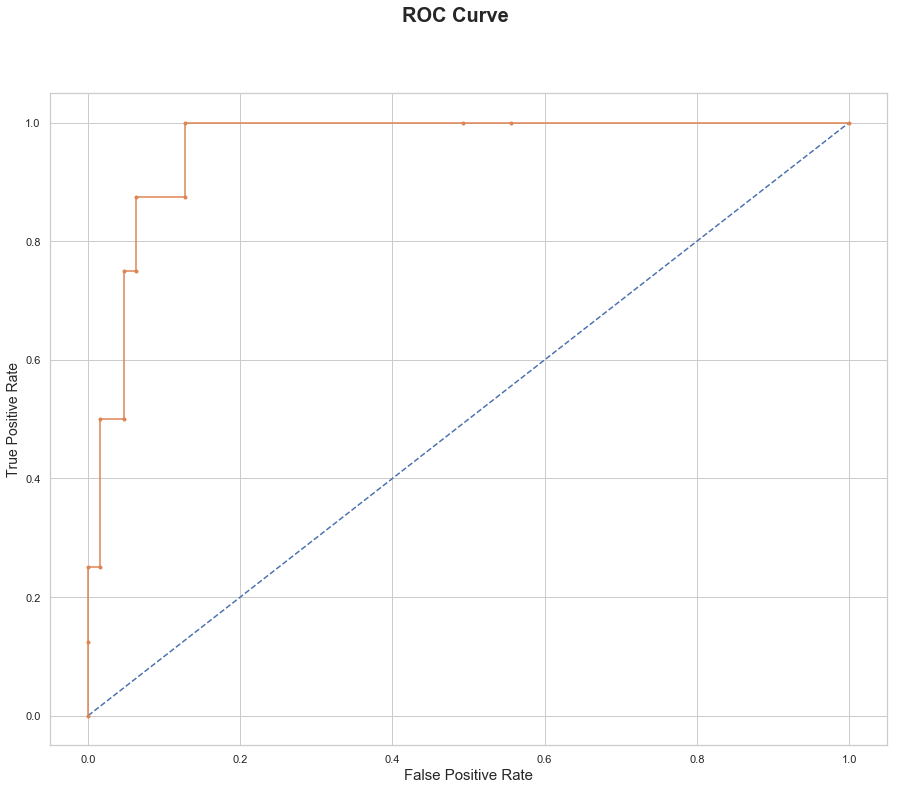

In [23]:
fig, ax = plt.subplots(figsize=(15,12))

# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test["5_org_mngmt"].astype(int), predicted_prob[:,1])

plt.suptitle("ROC Curve", fontsize=20, weight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize=14)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

***  

### (5) Classification Report

In [24]:
target_names = ['False', 'True']
print(classification_report(y_test["2_proj_mngmt"].astype(int), y_pred, target_names=target_names))

              precision    recall  f1-score   support

       False       0.65      1.00      0.79        46
        True       0.00      0.00      0.00        25

   micro avg       0.65      0.65      0.65        71
   macro avg       0.32      0.50      0.39        71
weighted avg       0.42      0.65      0.51        71



/Users/yukolopez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yukolopez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yukolopez/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


***  
### Baseline Results: Making predictions for unlabeled data

In [25]:
# Now we will find unlabeled rows for '2_proj_mngmt':
unlabeled_rows = monster_df.loc[monster_df['5_org_mngmt'].isnull()]
unlabeled_rows = unlabeled_rows.dropna(subset=["job_description"])

In [26]:
# Preproccessing
X_unlabeled = unlabeled_rows['job_description']
#y = unlabeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']] --> I don't need this.

In [27]:
X_unlabeled = count_vectorizer.transform(X_unlabeled)
X_unlabeled_tf = tfidf_transformer.transform(X_unlabeled)
#print(X_unlabeled_tf)
# print(X_unlabeled)

In [28]:
unlabeled_pred_result = classifier.predict_proba(X_unlabeled_tf)
unlabeled_pred_result #Probability estimates --> Look for the values, where the differece between x and y values are smallest

array([[0.83188293, 0.16811707],
       [0.79229037, 0.20770963],
       [0.68945752, 0.31054248],
       ...,
       [0.8545896 , 0.1454104 ],
       [0.84254112, 0.15745888],
       [0.78753185, 0.21246815]])

In [29]:
unlabeled_rows["prob_false"] = unlabeled_pred_result[:,0]
unlabeled_rows["prob_true"] = unlabeled_pred_result[:,1]
unlabeled_rows["label_prob_diff"] = unlabeled_rows["prob_false"] - unlabeled_rows["prob_true"]
unlabeled_rows[["prob_false", "prob_true", "label_prob_diff"]].sort_values(by="label_prob_diff", ascending=False)
subset = unlabeled_rows[unlabeled_rows["label_prob_diff"].between(-10,10)] #Use func, between.
subset = subset[["prob_false", "prob_true", "label_prob_diff", "uniq_id" ]].sort_values(by="label_prob_diff", ascending=True)

***  

# 5. (1) Building Pipeline: Improve classification: LR with LDA


In [30]:
X_labeled_text = labeled_rows['job_description'] #Text job descriptions
y_labeled = labeled_rows[['1_self_mngmt', '2_proj_mngmt', '3_ppl_mngmt', '4_prog_mngmt', '5_org_mngmt']]

In [31]:
X_all = monster_df["job_description"].dropna()

In [32]:
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# Define Search Param
search_params = {'n_components': [40, 45, 50], 'learning_decay': [0.7, 0.8, 0.9], 
                 'C': [0.85, 1.0]}

# For best_or_model, consider C=, 
# count_vectorizer_lda to be added to the search_params -(e.g.) min_df=100, max_df=0.7
grid = ParameterGrid(search_params)

#These are for lda model:
#Use BoW, not tfidf because BoW is the assumption that lda uses
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
X_bow = count_vectorizer_lda.fit_transform(X_all) # X_all = monster_df["job_description"].dropna()

for params in grid:
    best_lda_model = LatentDirichletAllocation(n_components=params['n_components'], 
                                               learning_decay=params['learning_decay'], 
                                               max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
    best_lda_model.fit(X_bow) # Fits the model on the entire dataset
    X_labeled = count_vectorizer_lda.transform(X_labeled_text) 
    # Take the above fitted data to take to the LR model.  To do so, first apply count_vectorizer and apply LDA model.
    X_labeled = best_lda_model.transform(X_labeled) 

    X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=42)
    # y_test['2_proj_mngmt']

    best_lr_model = LogisticRegression(penalty='l2', solver='lbfgs', C=params['C'], class_weight='balanced')
    best_lr_model.fit(X_train, y_train["5_org_mngmt"].astype(bool))
    y_pred = best_lr_model.predict(X_test) #Predict class labels for samples in X

    #cv_scores = cross_val_score(best_lr_model, X_test, y_pred, cv=2)
    
    cross_entropy = log_loss(y_test["5_org_mngmt"].astype(bool), y_pred, eps=1e-15)
    
    predicted_prob = best_lr_model.predict_proba(X_test)
    rocauc_score = roc_auc_score(y_test["5_org_mngmt"].astype(bool), predicted_prob[:,1])
    accuracy_score = best_lr_model.score(X_test, y_test["5_org_mngmt"].astype(bool))
    
    weighted_f1_score = f1_score(y_test["5_org_mngmt"].astype(bool), y_pred, average='weighted')  
    macro_f1_score = f1_score(y_test["5_org_mngmt"].astype(bool), y_pred, average='macro')  
    micro_f1_score = f1_score(y_test["5_org_mngmt"].astype(bool), y_pred, average='micro')
    
    print("Parameters: ", params,",", "\n"
          "Accuracy Score: ", accuracy_score,",", "\n"
          'F1 Weighted: ', weighted_f1_score, ",", "\n"
          'F1 Macro: ', macro_f1_score,",", "\n" 
          'F1 Micro: ', micro_f1_score, ",", "\n"
          'Log Loss: ', cross_entropy, ",", "\n"
          "ROC AUC: ", rocauc_score, "\n\n")

Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 40} , 
Accuracy Score:  0.8591549295774648 , 
F1 Weighted:  0.8658438083699329 , 
F1 Macro:  0.681899641577061 , 
F1 Micro:  0.8591549295774648 , 
Log Loss:  4.864683965263211 , 
ROC AUC:  0.8472222222222222 


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 45} , 
Accuracy Score:  0.8169014084507042 , 
F1 Weighted:  0.8349158310746019 , 
F1 Macro:  0.6367571822117276 , 
F1 Micro:  0.8169014084507042 , 
Log Loss:  6.3241026691649385 , 
ROC AUC:  0.8650793650793651 


Parameters:  {'C': 0.85, 'learning_decay': 0.7, 'n_components': 50} , 
Accuracy Score:  0.8591549295774648 , 
F1 Weighted:  0.8748399487836109 , 
F1 Macro:  0.7310606060606061 , 
F1 Micro:  0.8591549295774648 , 
Log Loss:  4.864706489134485 , 
ROC AUC:  0.9166666666666666 


Parameters:  {'C': 0.85, 'learning_decay': 0.8, 'n_components': 40} , 
Accuracy Score:  0.8450704225352113 , 
F1 Weighted:  0.8640899103058247 , 
F1 Macro:  0.7146510778224

***  
# 5. (2) Applying the best LDA parameters and display topics

In [33]:
X_all = monster_df["job_description"].dropna()

# This produces a feature matrix of token counts, similar to what
# CountVectorizer would produce on text.
#count_vectorizer_lda = CountVectorizer(stop_words="english", preprocessor=clean_text, min_df=100, max_df=0.5)
count_vectorizer_lda = CountVectorizer(stop_words=stopwords_lst, preprocessor=clean_text, min_df=100, max_df=0.7)
# LDA is unsupervised, which means no label required.  

X_bow = count_vectorizer_lda.fit_transform(X_all) # X came from X = labeled_rows['job_description']
# X_tfidf = tfidf_transformer.fit_transform(X_bow)

X_bow_feature_names = count_vectorizer_lda.get_feature_names()

lda = LatentDirichletAllocation(n_components=35, learning_decay=0.5, max_iter=100, batch_size=128, evaluate_every=5, n_jobs=-1)
# # doc_topic_prior=0.05, topic_word_prior=0.05
# # doc_topic_prior --> Alpha, prior of document topic distribution theta. If the value is None, defaults to 1 / n_components.
# # topic_word_prior --> Eta, prior of topic word distribution beta. If the value is None, defaults to 1 / n_components. 

lda.fit(X_bow) 
# # get topics for some given samples:
# lda.transform(X_bow[-2:]) # Picks two examples to show as print for the last two examples
# # (e.g.) array([[0.76497249, 0.00096665, 0.16679877, 0.06627602, 0.00098606],
# #        [0.3278557 , 0.01228623, 0.00148471, 0.13557174, 0.52280162]])
# # The above is the topic weights --> The higher the weight, the higher association of given topic given a doc
# # These topic weights is applied to the Log Reg model we already have.

# print(lda)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=5, learning_decay=0.5, learning_method='batch',
             learning_offset=10.0, max_doc_update_iter=100, max_iter=100,
             mean_change_tol=0.001, n_components=35, n_jobs=-1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [34]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 15
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, X_bow_feature_names, num_top_words)

Topic 0:
security brookdale apply whelan must people including requirements drug one living time background associates team
Topic 1:
company store ability merchandise customers general control skills assist perform cash procedures knowledge required duties
Topic 2:
team digital job skills media content time part sales able description important social events opportunity
Topic 3:
services company us solutions business opportunity companies world industry clients global employees leading com technology
Topic 4:
care patient patients medical nursing health required treatment clinical services needs certification staff state hospital
Topic 5:
customer customers service team products required ensure provide needs assist sales maintain including environment equipment
Topic 6:
business management project team ability skills development strong client projects process manage teams develop leadership
Topic 7:
job com www position online application candidates required please employment apply yea

***  

## Possible Interview Questions for 5_org_mngmt

In [2]:
interview_q_df = pd.read_excel("/Users/yukolopez/Desktop/SI630/Assignments/FinalProject/LR+LDA/behavioral_interview_q.xlsx", 
                 error_bad_lines=False, sheet_name="Sheet1", na_filter=False, encoding= 'utf-8')

In [3]:
interview_q_df = interview_q_df.replace({'T':True, 'F':False, '':np.nan})

In [4]:
interview_q_df['class_5'].unique()

array([True, False], dtype=object)

In [5]:
q = []
for each in interview_q_df['class_5'].unique(): 
    qs = interview_q_df.loc[interview_q_df['class_5'] == True][["q_id", "interview_q"]]
    q.append(qs)
#print(q)
for a in q:
    for index, b in a.iterrows():
        print(b["q_id"], b["interview_q"])

1 Tell me a little bit about yourself.
5 In what ways do you think you can make a contribution to our company? What makes you qualified for this position?
6 What would you do, or hope to accomplish in your first 90 days on the job?
7 Why did you leave your last job?   or Why do you want to leave your current employer?
8 Why have you had so many jobs in such a short period of time?
20 Give me an example of a problem you faced on the job, and tell me how you solved it.  
21 Give me an example of an important goal you had to set, and tell me about your progress in reaching that goal.
22 How do you deal with competition?  Are you a competitive person?
26 Tell me about a time you had to persuade or gain the cooperation of a group over which you had little or no authority.  What did you do?  How effective were you?
27 Talk about a time when you established a partnership, or an agreement with an internal customer so you could both achieve yoru business goals.  How did you go about that and ho